In [1]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from pathlib import Path
import numpy as np
import pandas as pd
import client_util
import os
import federated_model
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from keras.datasets import mnist
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [2]:
epochs = 100
NUM_CLASSES = 10

In [3]:
def clientDir(clientNum,cwd):
    folderPath = "client" + str(clientNum)
    folderDir = os.path.join(cwd,folderPath,'model_weights')
    if not os.path.isdir(folderDir):
        print('creating the model_weights folder')
        os.makedirs(folderDir)
    os.chdir(folderDir)

In [4]:
def perform_training(x_train,y_train,x_test,y_test,i,train,optimizer,cross_entropy,acc,x,y_actual,y_pred,keep_prob):
    N = len(x_train)
    idx = np.arange(N)
    batch_size = 100    
    cwd = os.getcwd()
    with tf.compat.v1.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_acc_list = []
        train_loss_list = []
        
        test_acc_list = []
        test_loss_list = []
    
        for epoch in range(epochs):
            #shuffle data 
            np.random.shuffle(idx)
            x_train, y_train = x_train[idx],y_train[idx]
            for start,end in zip(range(0,N,batch_size),range(batch_size,N,batch_size)):
                sess.run(train,feed_dict = {x:x_train[start:end], y_actual:y_train[start:end],keep_prob: 0.5})
        
        
            train_acc = acc.eval(feed_dict = {x:x_train, y_actual:y_train,keep_prob: 0.5})
            train_acc_list.append(train_acc)
        
            train_loss = cross_entropy.eval(feed_dict = {x:x_train, y_actual:y_train,keep_prob: 0.5})
            train_loss_list.append(train_loss)
        
            test_acc = acc.eval(feed_dict = {x:x_test, y_actual:y_test,keep_prob: 0.5})
            test_acc_list.append(test_acc)
            
            test_loss = cross_entropy.eval(feed_dict = {x:x_test, y_actual:y_test,keep_prob: 0.5})
            test_loss_list.append(test_loss)
           
            if epoch%20==0:
                print("Epoch: {}, Training accuracy: {}, Testing accuracy: {}, Training loss: {}".format(epoch,train_acc,test_acc,train_loss))
           
        for var in tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES):
            weight = (sess.run([var]))[0]
            filename = (str(var).split())[1].replace('/', '_')
            filename = filename.replace("'", "").replace(':0', '') + '.npy'
            print("saving {}".format(filename))
            clientDir(str(i+1),cwd)
            np.save(str(filename), weight,allow_pickle=True)
            
        plt.figure()
        plt.plot(range(epochs), train_loss_list, label='Training Loss')
        plt.plot(range(epochs), test_loss_list, label='Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Cross Entropy')
        plt.title("Cost against Training Epochs")
        plt.legend()
        plt.savefig('Loss.png')
        
        plt.figure()
        plt.plot(range(epochs), train_acc_list, label='Training Set')
        plt.plot(range(epochs), test_acc_list, label='Testing Set')
        plt.xlabel('Epochs')
        plt.ylabel('Prediction Accuracy')
        plt.title("Prediction Accuracy against Training Epochs")
        plt.legend()
        plt.savefig('Accuracy.png')
        
        os.chdir(cwd)

In [5]:
def trainingLoop(dataset):
    x_train,y_train,x_test,y_test = client_util.load_dataset(dataset)
    x_train,y_train,x_test,y_test = client_util.normalize_data(x_train,y_train,x_test,y_test)
    if dataset=="mnist" or dataset=="fashion_mnist":
        x_train = np.expand_dims(x_train,axis = -1)
        x_test = np.expand_dims(x_test,axis = -1)
        img_size = 28
        NUM_CHANNELS = 1
    else:
        img_size = 32
        NUM_CHANNELS = 3
        
    return x_train,y_train,x_test,y_test,NUM_CHANNELS,img_size

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_train type: <class 'numpy.ndarray'>, y_train type: <class 'numpy.ndarray'>
x_train shape: (60000, 28, 28), y_train shape: (60000, 10)
x_train type: <class 'numpy.ndarray'>, y_train type: <class 'numpy.ndarray'>
x_train shape: (60000, 28, 28, 1), y_train.shape: (60000, 10)
=================Setting up Cifar10 model=================




W1_shape: Tensor("conv_1/Shape:0", shape=(4,), dtype=int32), b1_shape: Tensor("conv_1/Shape_1:0", shape=(1,), dtype=int32)
W2_shape: Tensor("conv_2/Shape:0", shape=(4,), dtype=int32), b2_shape: Tensor("conv_2/Shape_1:0", shape=(1,), dtype=int32)
dim1 shape: 7, dim2 shape: 7, dim3 shape:60 
W_fc1_shape: Tensor("fc_1/Shape:0", shape=(2,), dtype=int32), b_fc1_shape: Tensor("fc_1/Shape_1:0", shape=(1,), dtype=int32)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W_fc2_shape: Tensor("Shape:0", shape=(2,), dtype=int32), b_fc2_shape: Tenso

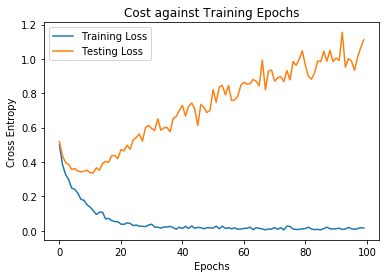

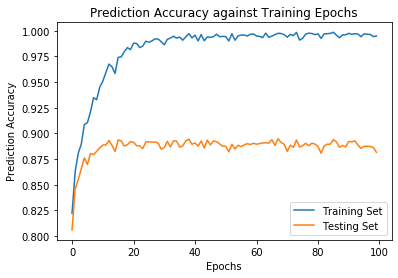

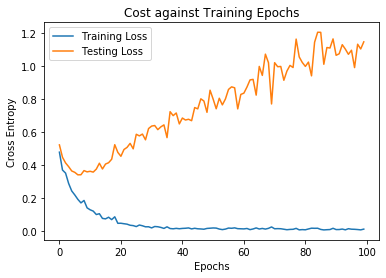

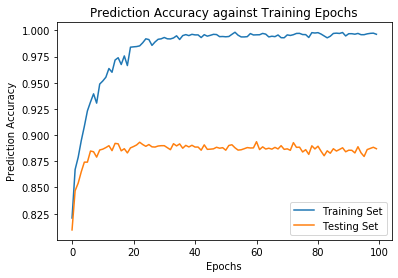

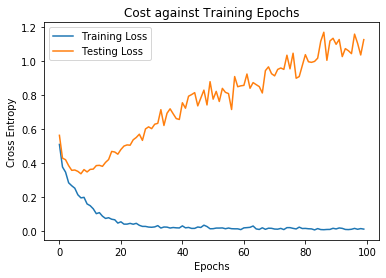

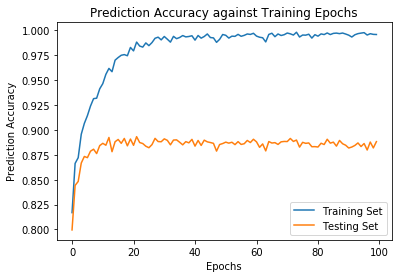

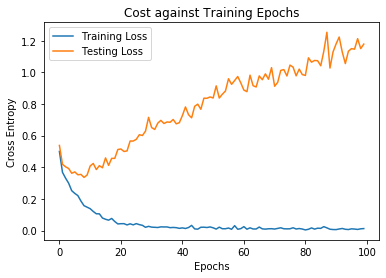

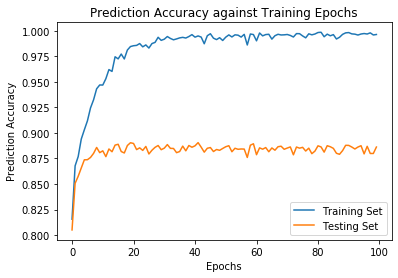

In [6]:
def main():
    datasets = ['cifar10','mnist','fashion_mnist']
    curr_dataset = datasets[2]
    
    
    #get data    
    #x_train_c,y_train_c,x_test,y_test = client_util.load_dataset(datasets[0])
    #x_train_c,y_train_c,x_test,y_test = client_util.normalize_data(x_train_c,y_train_c,x_test,y_test )
    x_train,y_train,x_test,y_test,NUM_CHANNELS,img_size = trainingLoop("fashion_mnist")
    print("x_train shape: {}, y_train.shape: {}".format(x_train.shape,y_train.shape))
    
    #split data for respective clients
    clients = client_util.repeatedSampling(x_train,y_train,4,"fashion_mnist")
    
    #declare placeholders
    x = tf.placeholder(tf.float32,shape=[None,img_size,img_size,NUM_CHANNELS])
    y_actual = tf.placeholder(tf.float32,shape=[None,NUM_CLASSES])
    keep_prob = tf.placeholder(tf.float32)
    
    y_pred = federated_model.model(x,y_actual,NUM_CHANNELS,keep_prob)
    #setting up loss function
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_actual,logits=y_pred))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train = optimizer.minimize(cross_entropy)
    
    with tf.variable_scope('acc',reuse = tf.AUTO_REUSE):
        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_actual,1))
        acc = tf.reduce_mean(tf.cast(matches,tf.float32)) 
    
    for i in range(len(clients)):
        print("============client {}===============".format(i+1))
        x_train = clients[i][0]
        y_train = clients[i][1]
        print("x_train shape: {}, y_train shape: {}".format(x_train.shape,y_train.shape))
        perform_training(x_train,y_train,x_test,y_test,i,train,optimizer,cross_entropy,acc,x,y_actual,y_pred,keep_prob)
    
if __name__ == '__main__':
    main()